In [27]:
!pip install tensorflow scikit-learn opencv-python



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

train_data_dir = r'real_vs_fake\real-vs-fake\test'
batch_size = 32
img_height, img_width = 224, 224

# Image data generator with rescaling
datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create training generator
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

# Load ResNet50 model 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)  
feature_extractor_model = Model(inputs=base_model.input, outputs=x)

# Extract features and labels for the entire training dataset
train_features = []
train_labels = []

for images, labels in train_generator:
    features = feature_extractor_model.predict(images)
    train_features.extend(features)
    train_labels.extend(labels)
    
    if len(train_features) >= train_generator.samples: 
        break

# Convert to numpy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)
print(f"Feature shape: {train_features.shape}")
print("Unique labels in train_labels:", np.unique(train_labels))

# Initialize and train SVM on the extracted features
svm_classifier = SVC(kernel='linear', probability=True)
svm_classifier.fit(train_features, train_labels)

# Define the prediction function
import cv2

def predict_image(image_path, feature_extractor_model, svm_classifier):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_height, img_width))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)

    # Extract features
    features = feature_extractor_model.predict(img)
    
    # Predict with SVM
    prediction = svm_classifier.predict(features)
    probability = svm_classifier.predict_proba(features)

    # Return results
    return "Au" if prediction[0] == 1 else "Tp", probability[0][int(prediction[0])]



Found 20000 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━

In [ ]:
# Example 
image_path = r'real_vs_fake\real-vs-fake\test\fake\0A266M95TD.jpg' 
result, confidence = predict_image(image_path, feature_extractor_model, svm_classifier)
print(f"Prediction: {result} image")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Prediction: Tp image


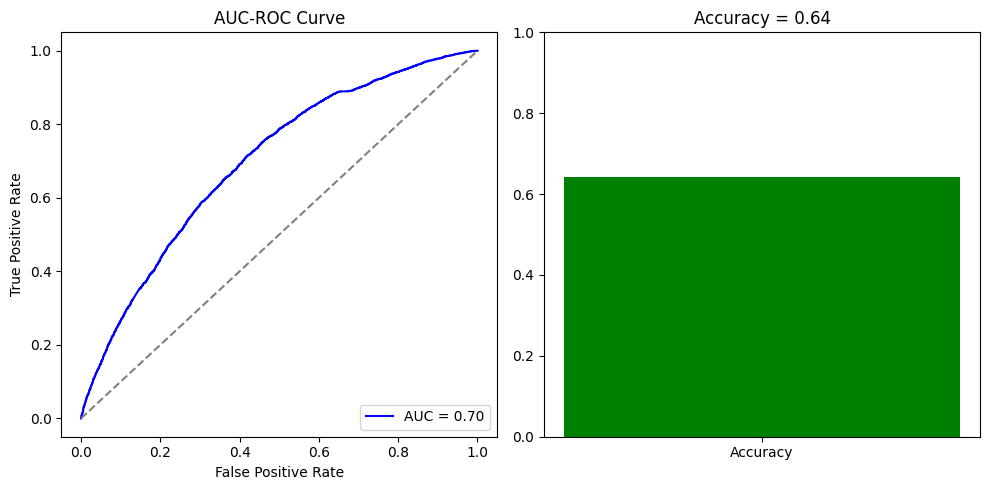

In [12]:
# Plot AUC-ROC and Accuracy Curves
def plot_auc_roc(train_features, train_labels, svm_classifier):
    # Predict probabilities for AUC-ROC
    probs = svm_classifier.predict_proba(train_features)[:, 1]
    fpr, tpr, thresholds = roc_curve(train_labels, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 5))

    # Plot AUC-ROC
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC Curve')
    plt.legend(loc="lower right")
 # Plot Accuracy
    plt.subplot(1, 2, 2)
    accuracy = accuracy_score(train_labels, svm_classifier.predict(train_features))
    plt.bar(['Accuracy'], [accuracy], color='green')
    plt.ylim(0, 1)
    plt.title(f'Accuracy = {accuracy:.2f}')
    
    plt.tight_layout()
    plt.show()

# Plot the AUC-ROC and accuracy
plot_auc_roc(train_features, train_labels, svm_classifier)

   


In [10]:
pip install tf-keras


  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl.metadata (4.9 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl (7.5 kB)
Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl (390.3 MB)
Using cached tensorboard-2.18.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow-intel
    Found existing installation: tensorflow-intel 2.17.0
    Uninstalling tensorflow-intel-2.17.0:
      Successfully uninstalled tensorflow-intel-2.17.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:
      Successfully uninstalled tensorflow-2.17.0
Note: you may need to restart th

  You can safely remove it manually.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install tensorflow==2.17.0

  Using cached keras-3.7.0-py3-none-any.whl.metadata (5.8 kB)
Using cached keras-3.7.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install keras==2.11.0



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
pip show tensorflow


Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: d:\local_drive\Lib\site-packages
Requires: tensorflow-intel
Required-by: tf_keras
Note: you may need to restart the kernel to use updated packages.


In [22]:
pip show keras


Name: keras
Version: 3.7.0
Summary: Multi-backend Keras
Home-page: 
Author: 
Author-email: Keras team <keras-users@googlegroups.com>
License: Apache License 2.0
Location: d:\local_drive\Lib\site-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, packaging, rich
Required-by: tensorflow_intel
Note: you may need to restart the kernel to use updated packages.


In [25]:
pip install --upgrade keras


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


<h1>FOR IMAGE</h1>

Found 12614 images belonging to 2 classes.
Class indices: {'Au': 0, 'Tp': 1}
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━

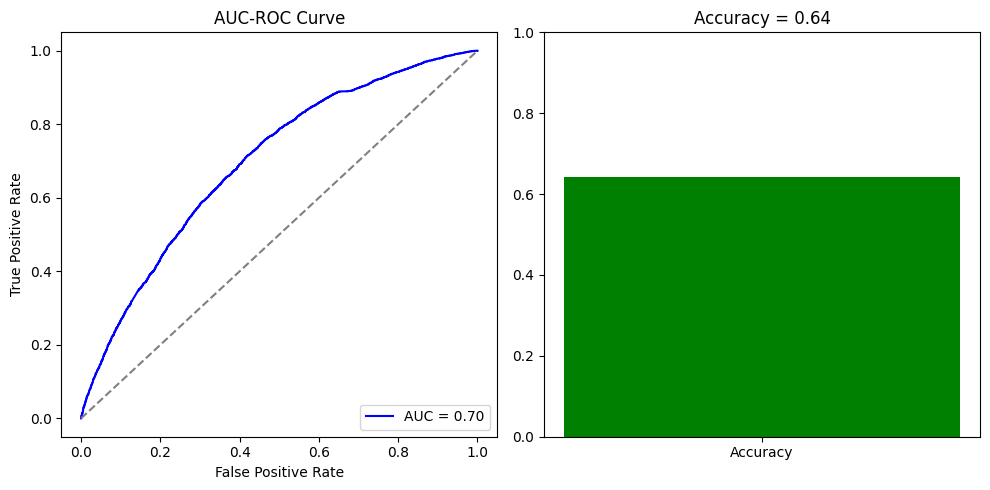

In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import cv2

# Directories
train_data_dir = r'D:\MINOR_PROJECT\Tamper\CASIA2'  # Replace with your actual path
image_path = r'D:\MINOR_PROJECT\Tamper\CASIA2\Au\Au_ani_00009.jpg'  # Test image path

# Parameters
batch_size = 32
img_height, img_width = 224, 224

# Step 1: Prepare the data
datagen = ImageDataGenerator(rescale=1.0 / 255)
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

# Check label mapping
print("Class indices:", train_generator.class_indices)

# Step 2: Load ResNet50 for feature extraction
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
feature_extractor_model = Model(inputs=base_model.input, outputs=x)

# Step 3: Extract features and labels from the training data
train_features = []
train_labels = []

for images, labels in train_generator:
    features = feature_extractor_model.predict(images)
    train_features.extend(features)
    train_labels.extend(labels)
    
    if len(train_features) >= train_generator.samples:
        break

train_features = np.array(train_features)
train_labels = np.array(train_labels)
print(f"Feature shape: {train_features.shape}")
print("Unique labels:", np.unique(train_labels))

# Step 4: Train SVM classifier
svm_classifier = SVC(kernel='linear', probability=True)
svm_classifier.fit(train_features, train_labels)

# Step 5: Define prediction function
def predict_image(image_path, feature_extractor_model, svm_classifier):
    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_height, img_width))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)
    
    # Extract features and predict
    features = feature_extractor_model.predict(img)
    prediction = svm_classifier.predict(features)
    probability = svm_classifier.predict_proba(features)
    
    label = "Real" if prediction[0] == 1 else "Fake"
    confidence = probability[0][int(prediction[0])]
    
    return label, confidence

# Step 6: Plot AUC-ROC and accuracy
def plot_auc_roc(train_features, train_labels, svm_classifier):
    probs = svm_classifier.predict_proba(train_features)[:, 1]
    fpr, tpr, thresholds = roc_curve(train_labels, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 5))
    
    # AUC-ROC curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC Curve')
    plt.legend(loc="lower right")
    
    # Accuracy bar plot
    plt.subplot(1, 2, 2)
    accuracy = accuracy_score(train_labels, svm_classifier.predict(train_features))
    plt.bar(['Accuracy'], [accuracy], color='green')
    plt.ylim(0, 1)
    plt.title(f'Accuracy = {accuracy:.2f}')
    
    plt.tight_layout()
    plt.show()

# Step 7: Test the model
result, confidence = predict_image(image_path, feature_extractor_model, svm_classifier)
print(f"Prediction: {result} image, Confidence: {confidence:.2f}")

# Step 8: Visualize the metrics
plot_auc_roc(train_features, train_labels, svm_classifier)


<h1>TAMPERING DETECTION USING VIT + CNN HYBRID MODEL</h1>

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [4]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
from transformers import ViTModel

d:\local_drive\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class CNN_ViT_Hybrid(nn.Module):
    def __init__(self, num_classes):
        super(CNN_ViT_Hybrid, self).__init__()
        # CNN backbone (ResNet50)
        self.cnn = resnet50(pretrained=True)
        self.cnn.fc = nn.Identity()  

        # Vision Transformer (ViT)
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.vit_fc = nn.Linear(self.vit.config.hidden_size, 256)

        # Final classification layer
        self.fc = nn.Linear(256 + 2048, num_classes)

    def forward(self, x):
        # Extract features from CNN
        cnn_features = self.cnn(x)

        # Extract features from ViT
        vit_features = self.vit(pixel_values=x).pooler_output
        vit_features = self.vit_fc(vit_features)

        # Concatenate features and classify
        combined_features = torch.cat((cnn_features, vit_features), dim=1)
        out = self.fc(combined_features)
        return out

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load training dataset
train_dataset = datasets.ImageFolder(root=r'COVID_19', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)




In [ ]:
model = CNN_ViT_Hybrid(num_classes=2)  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


d:\local_drive\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\local_drive\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10  

In [13]:
for epoch in range(10):  
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/10], Loss: {running_loss/len(train_loader):.4f}")




Epoch [1/10], Loss: 0.8170
Epoch [2/10], Loss: 0.5547
Epoch [3/10], Loss: 0.4093
Epoch [4/10], Loss: 0.2449
Epoch [5/10], Loss: 0.1835
Epoch [6/10], Loss: 0.2039
Epoch [7/10], Loss: 0.0858
Epoch [8/10], Loss: 0.0596
Epoch [9/10], Loss: 0.1705
Epoch [10/10], Loss: 0.0600


In [14]:
# Set model to evaluation mode
model.eval()

correct = 0
total = 0

with torch.no_grad():  
    for images, labels in train_loader:  
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on validation images: {accuracy:.2f}%')


Accuracy of the model on validation images: 96.00%


In [ ]:
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(model, dataloader):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs[:, 1].cpu().numpy())  

    # Calculate FPR, TPR
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


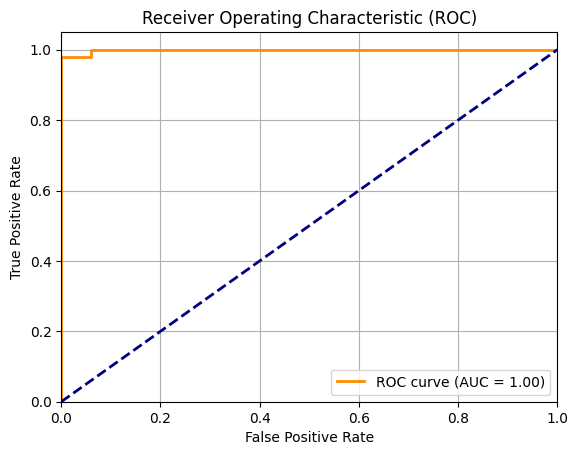

In [16]:
plot_roc_curve(model, train_loader)


In [ ]:
from PIL import Image

def predict_single_image(model, image_path, device):
    model.eval()

    # Image transforms (same as training)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    # Load and preprocess the image
    img = Image.open(image_path).convert('RGB')
    img = transform(img)
    img = img.unsqueeze(0) 
    img = img.to(device)

    with torch.no_grad():
        output = model(img)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    class_names = ['Authentic (Au)', 'Tampered (Tp)']
    print(f'Predicted class: {class_names[predicted_class]}')
    print(f'Confidence: {probabilities.squeeze()[predicted_class].item()*100:.2f}%')

    return predicted_class


In [27]:
# After you trained your model
image_path = r'COVID_19\c normal\c (3).png'  
predict_single_image(model, image_path, device)


Predicted class: Tampered (Tp)
Confidence: 99.97%


1

<h1> LOCALIZE THE TAMPERED REGION USING SSIM AND PSNR </h1>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

class TamperDetectionWithReference:
    def __init__(self, input_size=500, show_result=True, similarity_thresh=0.6):
        self.input_size = input_size
        self.similarity_thresh = similarity_thresh
        self.show_result = show_result

    def detect_tampering(self, real_image_path, tampered_image_path):
        # Load images
        real_img = cv2.imread(real_image_path)
        tampered_img = cv2.imread(tampered_image_path)

        if real_img is None or tampered_img is None:
            raise ValueError("Error: Could not load one or both images.")

        # Resize both images
        real_img = cv2.resize(real_img, (self.input_size, self.input_size))
        tampered_img = cv2.resize(tampered_img, (self.input_size, self.input_size))

        # Convert to grayscale
        gray_real = cv2.cvtColor(real_img, cv2.COLOR_BGR2GRAY)
        gray_tampered = cv2.cvtColor(tampered_img, cv2.COLOR_BGR2GRAY)

        # SSIM comparison
        ssim_score, diff = ssim(gray_real, gray_tampered, full=True)
        diff = (1 - diff)  
        diff = (diff * 255).astype("uint8")

        # PSNR comparison
        psnr_score = psnr(gray_real, gray_tampered)

        # Threshold the difference map
        _, thresh = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        tampered_detected = False
        boxed_img = tampered_img.copy()
        highlighted_img = tampered_img.copy()
        mask = np.zeros_like(gray_real)

        for contour in contours:
            if cv2.contourArea(contour) > 20:  # Filter out very small areas
                tampered_detected = True
                x, y, w, h = cv2.boundingRect(contour)
                cv2.rectangle(boxed_img, (x, y), (x+w, y+h), (0, 255, 0), 2)  # green box
                cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)

        # Highlight tampered regions
        highlighted_img[mask == 255] = [0, 0, 255]  # Highlight in Red

        # Visualization
        if self.show_result:
            self.show_results(real_img, tampered_img, boxed_img, highlighted_img, diff, thresh, ssim_score, psnr_score, tampered_detected)

        return tampered_detected, ssim_score, psnr_score

    def show_results(self, real_img, tampered_img, boxed_img, highlighted_img, diff, thresh, ssim_score, psnr_score, tampered_detected):
        status = "TAMPERING DETECTED" if tampered_detected else "NO TAMPERING DETECTED"

        fig, axs = plt.subplots(2, 3, figsize=(18, 10))
        
        axs[0,0].imshow(cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB))
        axs[0,0].set_title("Original Image", fontsize=14)
        axs[0,0].axis('off')

        axs[0,1].imshow(cv2.cvtColor(tampered_img, cv2.COLOR_BGR2RGB))
        axs[0,1].set_title("Tampered Image", fontsize=14)
        axs[0,1].axis('off')

        axs[0,2].imshow(diff, cmap='gray')
        axs[0,2].set_title("SSIM Difference Map", fontsize=14)
        axs[0,2].axis('off')

        axs[1,0].imshow(thresh, cmap='gray')
        axs[1,0].set_title("Thresholded Map", fontsize=14)
        axs[1,0].axis('off')

        axs[1,1].imshow(cv2.cvtColor(boxed_img, cv2.COLOR_BGR2RGB))
        axs[1,1].set_title("Detected Bounding Boxes", fontsize=14)
        axs[1,1].axis('off')

        axs[1,2].imshow(cv2.cvtColor(highlighted_img, cv2.COLOR_BGR2RGB))
        axs[1,2].set_title("Localized Tampered Regions", fontsize=14)
        axs[1,2].axis('off')

        plt.suptitle(f"{status}\nSSIM: {ssim_score:.4f}, PSNR: {psnr_score:.2f} dB", fontsize=18)
        plt.tight_layout()
        plt.show()


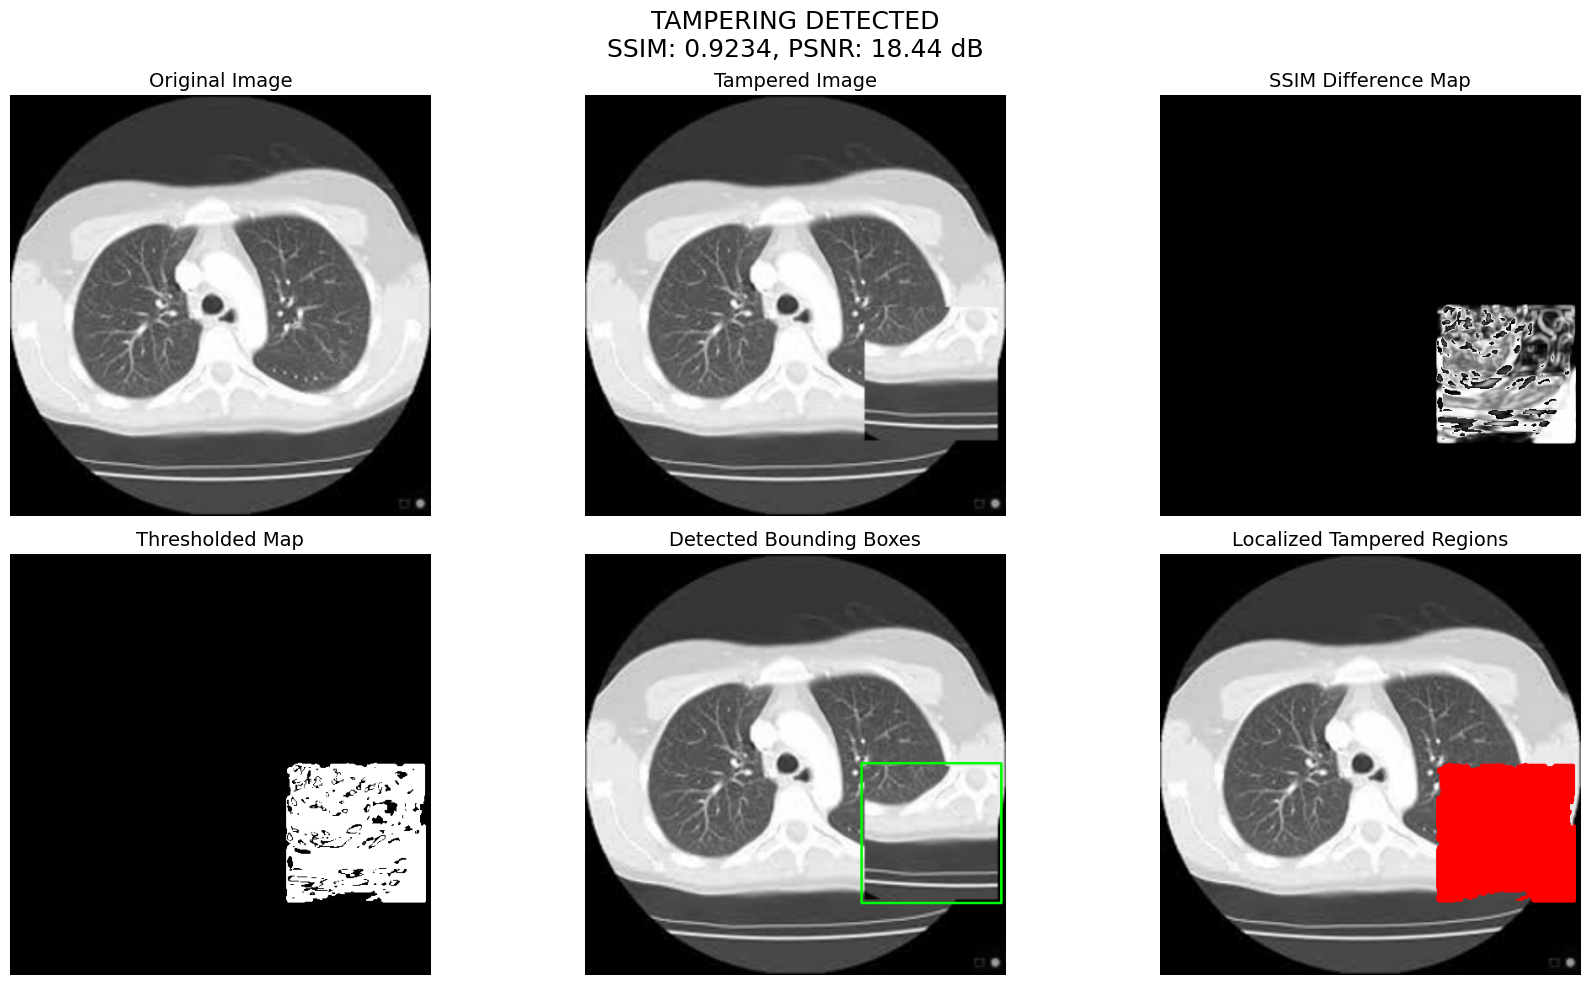

[INFO] Tampering detected! SSIM: 0.9234, PSNR: 18.44 dB


In [ ]:
real_image_path = r"Medical_dataset\original\original\original (1).png"  
tampered_image_path = r"Medical_dataset\copy_move\copy_move\copy_move (1).png"  

detector = TamperDetectionWithReference(show_result=True)
tampered, ssim_score, psnr_score = detector.detect_tampering(real_image_path, tampered_image_path)

if tampered:
    print(f"[INFO] Tampering detected! SSIM: {ssim_score:.4f}, PSNR: {psnr_score:.2f} dB")
else:
    print(f"[INFO] No tampering detected. SSIM: {ssim_score:.4f}, PSNR: {psnr_score:.2f} dB")


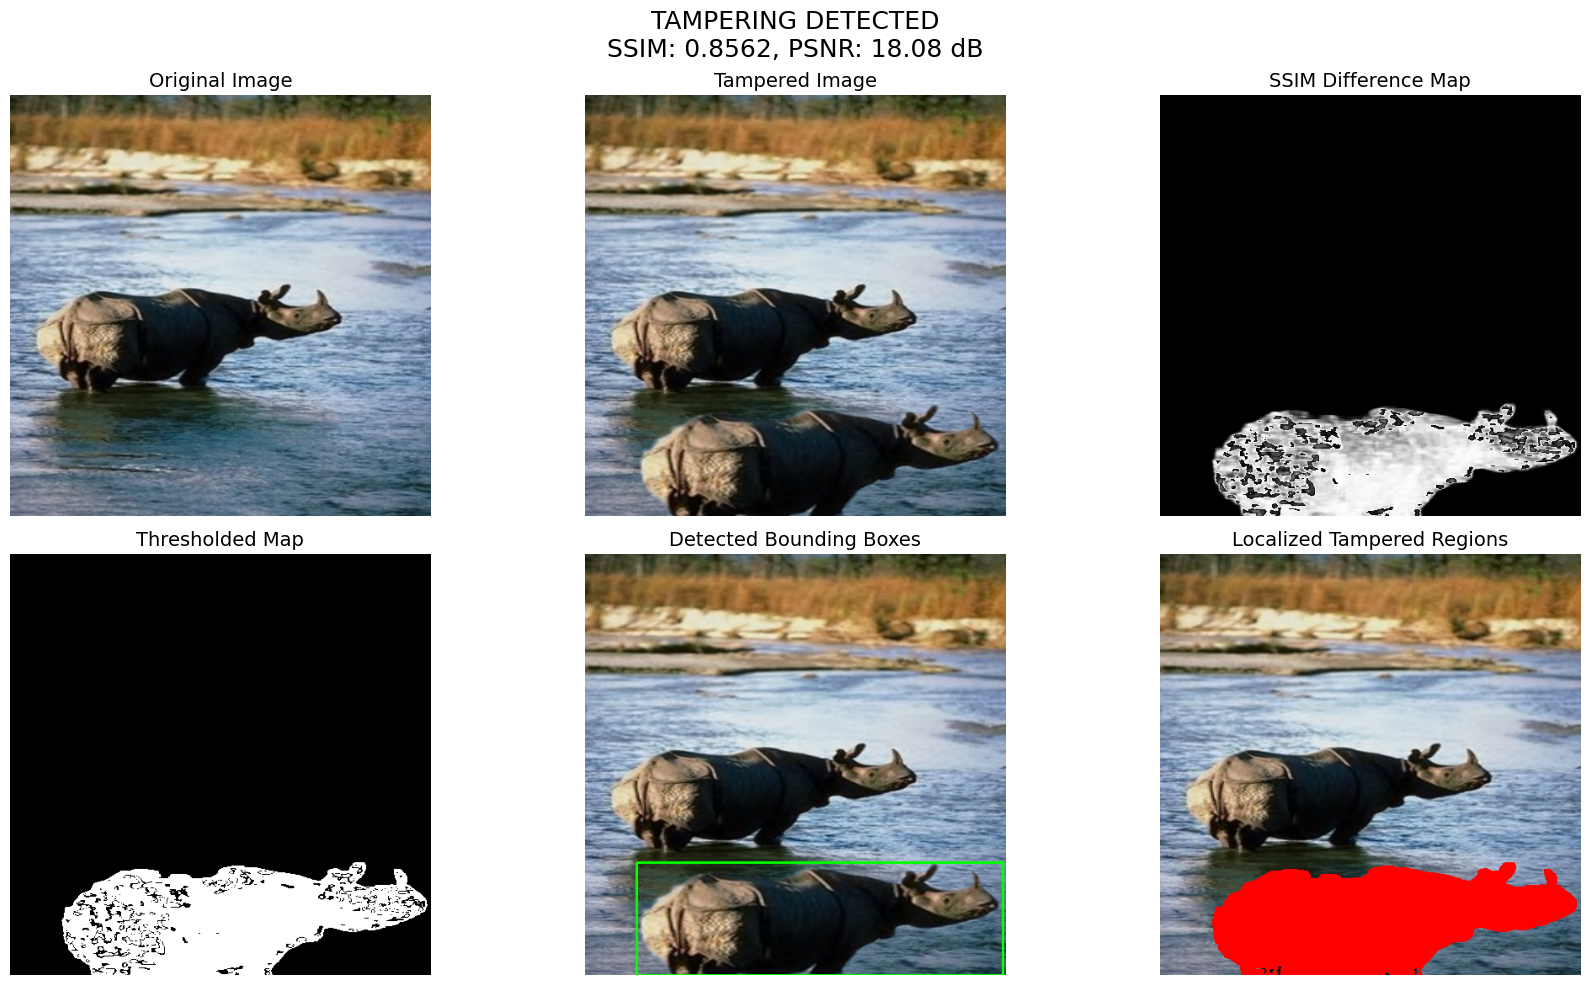

[INFO] Tampering detected! SSIM: 0.8562, PSNR: 18.08 dB


In [ ]:
real_image_path = r"tamper image\Au\Au_ani_00045.jpg" 
tampered_image_path = r"tamper image\TP\Tp_S_NRN_S_N_ani00045_ani00045_00831.tif"  

detector = TamperDetectionWithReference(show_result=True)
tampered, ssim_score, psnr_score = detector.detect_tampering(real_image_path, tampered_image_path)

if tampered:
    print(f"[INFO] Tampering detected! SSIM: {ssim_score:.4f}, PSNR: {psnr_score:.2f} dB")
else:
    print(f"[INFO] No tampering detected. SSIM: {ssim_score:.4f}, PSNR: {psnr_score:.2f} dB")


<h1>RECOVER THE TAMPERED REGION USINF DWT</h1>

In [ ]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    """Load and preprocess image for CNN feature extraction"""
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found at path: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img, img_array

def extract_cnn_features(model, img_array):
    """Extract features using pre-trained CNN"""
    return model.predict(img_array)

def compute_feature_similarity(feat1, feat2):
    """Compute similarity between CNN features"""
    return np.linalg.norm(feat1 - feat2)

def detect_tampered_regions(authentic_img, tampered_img, window_size=7):
    """Detect tampered regions using SSIM"""
    # Convert to grayscale
    authentic_gray = cv2.cvtColor(authentic_img, cv2.COLOR_RGB2GRAY)
    tampered_gray = cv2.cvtColor(tampered_img, cv2.COLOR_RGB2GRAY)
    
    # Compute SSIM
    score, diff = ssim(authentic_gray, tampered_gray, 
                       full=True, win_size=window_size)
    
    # Normalize and threshold the difference
    diff = (diff * 255).astype("uint8")
    _, threshold_map = cv2.threshold(diff, 0, 255, 
                                    cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    
    return threshold_map, score

def recover_tampered_image(authentic_img, tampered_img, threshold_map):
    """Recover tampered image using DWT"""
    # Convert to grayscale
    authentic_gray = cv2.cvtColor(authentic_img, cv2.COLOR_RGB2GRAY)
    tampered_gray = cv2.cvtColor(tampered_img, cv2.COLOR_RGB2GRAY)
    
    # Perform DWT
    authentic_coeffs = pywt.dwt2(authentic_gray, 'haar')
    tampered_coeffs = pywt.dwt2(tampered_gray, 'haar')
    
    authentic_cA, (authentic_cH, authentic_cV, authentic_cD) = authentic_coeffs
    tampered_cA, (tampered_cH, tampered_cV, tampered_cD) = tampered_coeffs

    threshold_map_resized = cv2.resize(threshold_map, 
                                     (authentic_cA.shape[1], authentic_cA.shape[0]), 
                                     interpolation=cv2.INTER_NEAREST)
    
    # Recover tampered regions
    recovered_cA = np.where(threshold_map_resized > 0, authentic_cA, tampered_cA)
    
    # Reconstruct image
    recovered_image = pywt.idwt2((recovered_cA, (tampered_cH, tampered_cV, tampered_cD)), 'haar')
    recovered_image = np.clip(recovered_image, 0, 255).astype(np.uint8)
    
    return recovered_image

def combined_tampering_detection(authentic_path, tampered_path):
    # Load and preprocess images
    authentic_img, authentic_array = load_and_preprocess_image(authentic_path)
    tampered_img, tampered_array = load_and_preprocess_image(tampered_path)
    
    # Load pre-trained CNN model (VGG16 without top layers)
    base_model = VGG16(weights='imagenet', include_top=False)
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)
    
    # Extract features
    authentic_features = extract_cnn_features(model, authentic_array)
    tampered_features = extract_cnn_features(model, tampered_array)
    
    # Compute feature similarity
    feature_similarity = compute_feature_similarity(authentic_features, tampered_features)
    print(f"Feature similarity score: {feature_similarity}")
    
    # Detect tampered regions with SSIM
    threshold_map, ssim_score = detect_tampered_regions(authentic_img, tampered_img)
    print(f"SSIM score: {ssim_score}")
    
    # Recover tampered image with DWT
    recovered_image = recover_tampered_image(authentic_img, tampered_img, threshold_map)
    
    # Display results
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.title("Authentic Image")
    plt.imshow(authentic_img)
    plt.axis("off")
    
    plt.subplot(2, 3, 2)
    plt.title("Tampered Image")
    plt.imshow(tampered_img)
    plt.axis("off")
    
    plt.subplot(2, 3, 3)
    plt.title("Feature Similarity Heatmap")
    # For visualization, we'll show the difference between feature maps
    feat_diff = np.mean(np.abs(authentic_features - tampered_features), axis=-1).squeeze()
    plt.imshow(feat_diff, cmap='hot')
    plt.colorbar()
    plt.axis("off")
    
    plt.subplot(2, 3, 4)
    plt.title("SSIM Difference Map")
    plt.imshow(threshold_map, cmap='gray')
    plt.axis("off")
    
    plt.subplot(2, 3, 5)
    plt.title("Recovered Image (DWT)")
    plt.imshow(recovered_image, cmap='gray')
    plt.axis("off")
    
    # Show the recovered regions (highlighted)
    plt.subplot(2, 3, 6)
    plt.title("Recovered Regions")
    # Create a mask for recovered regions
    recovered_mask = cv2.resize(threshold_map, (recovered_image.shape[1], recovered_image.shape[0]))
    highlighted = cv2.merge([recovered_image, recovered_image, recovered_image])
    highlighted[:, :, 0] = np.where(recovered_mask > 0, 255, highlighted[:, :, 0])
    plt.imshow(highlighted)
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Feature similarity score: 1877.0809326171875
SSIM score: 0.8397707471545272


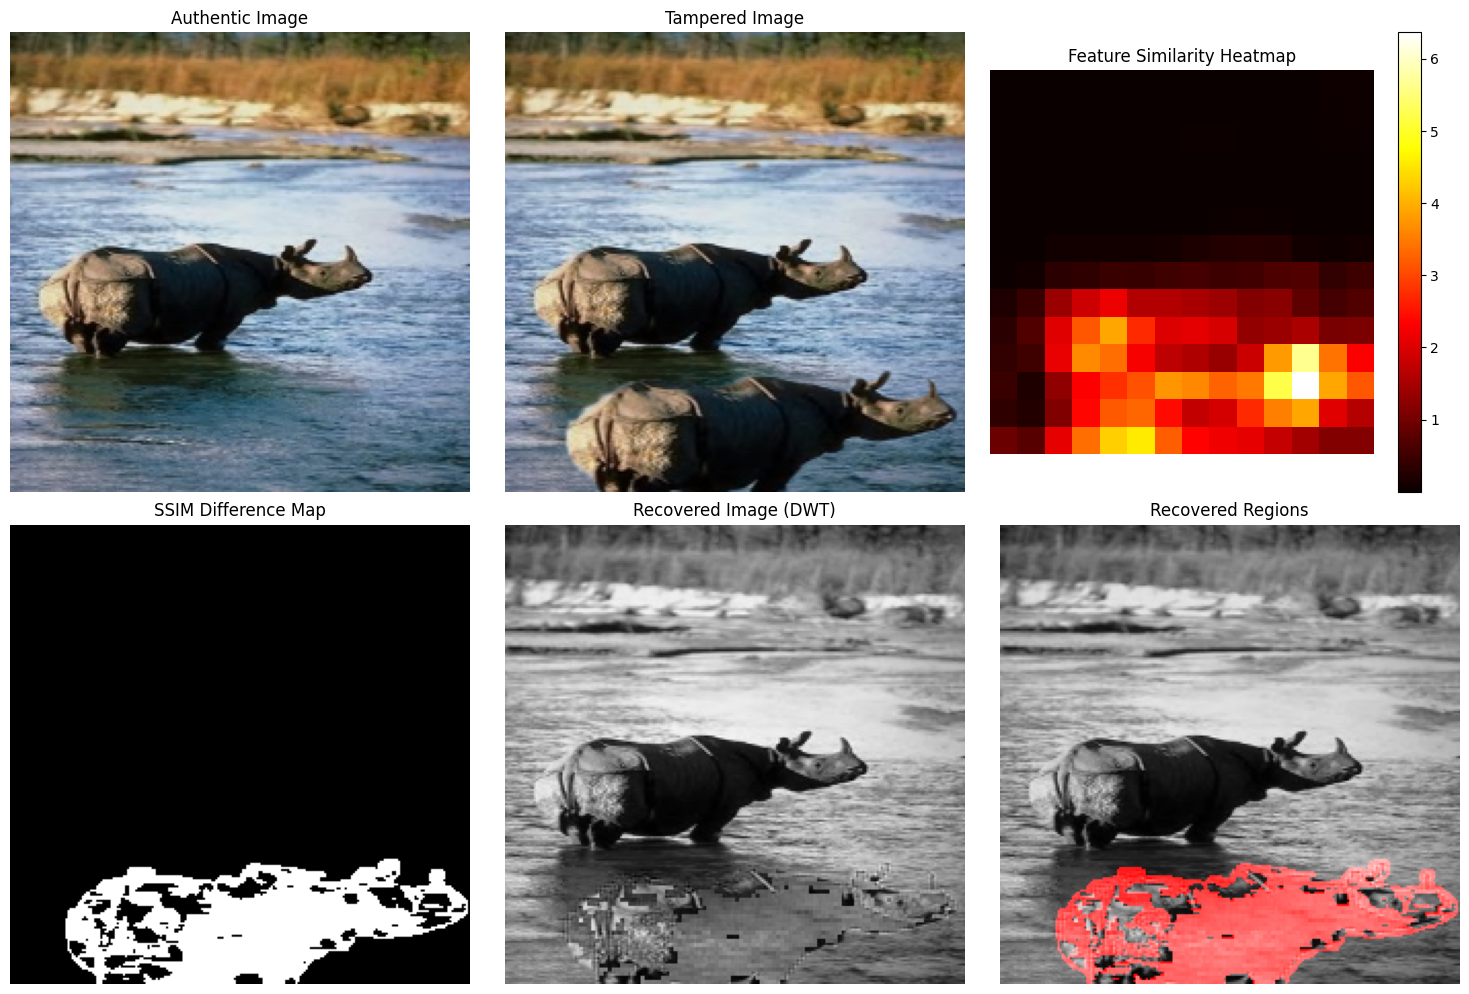

In [56]:
# Example usage
authentic_path = r"tamper image\Au\Au_ani_00045.jpg"
tampered_path = r"tamper image\TP\Tp_S_NRN_S_N_ani00045_ani00045_00831.tif"
combined_tampering_detection(authentic_path, tampered_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Feature similarity score: 1191.0028076171875
SSIM score: 0.9060660888868365


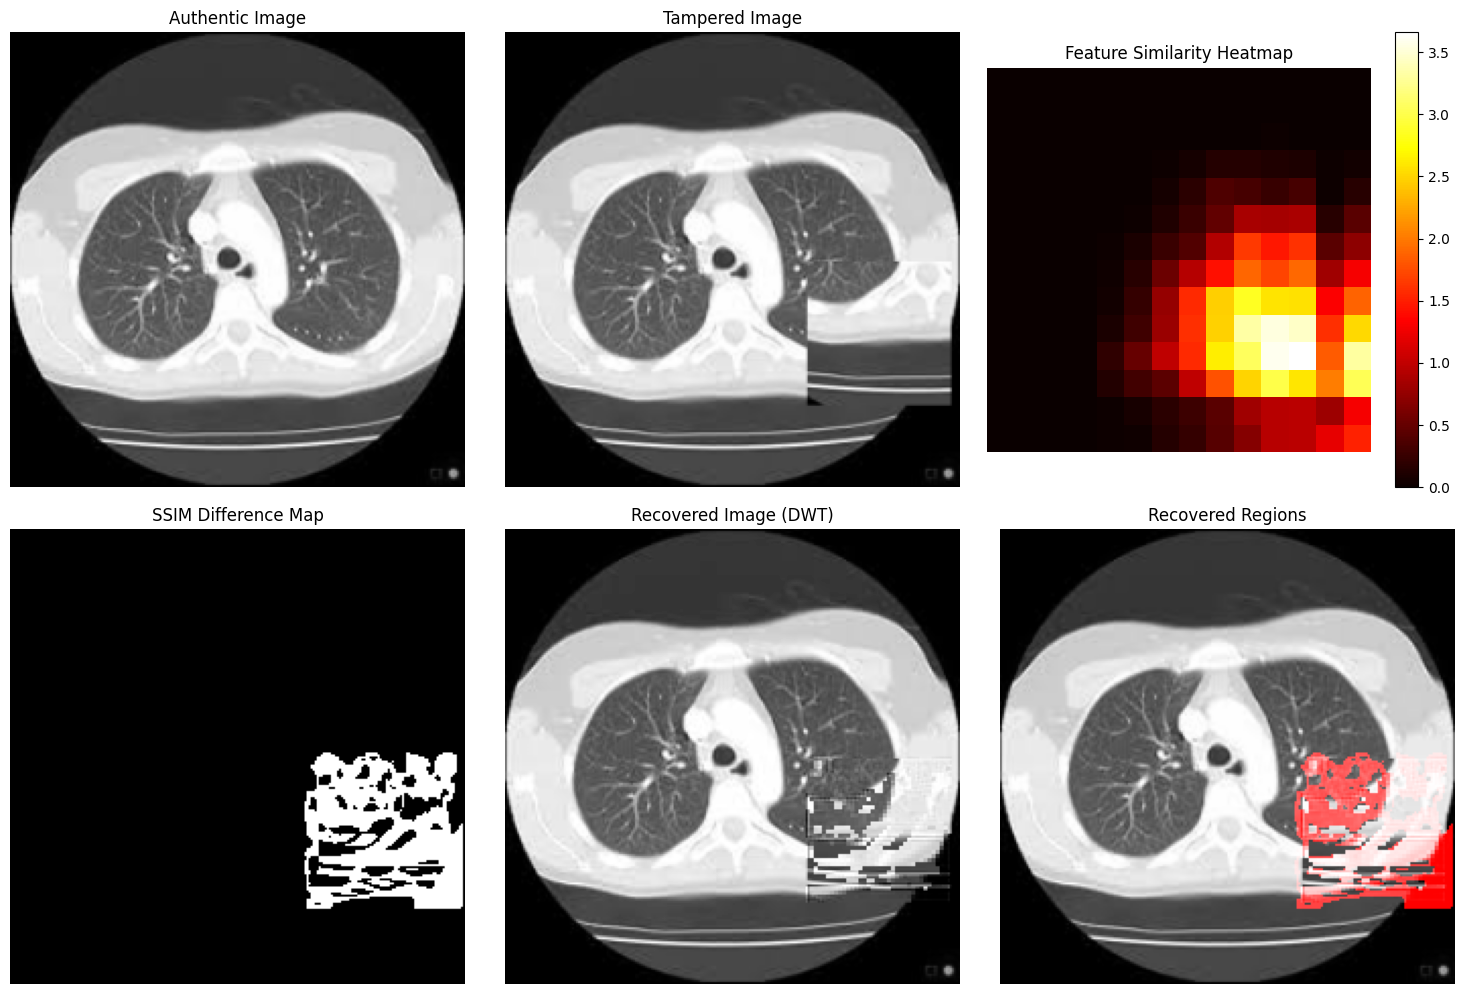

In [ ]:
# Example
authentic_path = r"Medical_dataset\original\original\original (1).png"
tampered_path = r"Medical_dataset\copy_move\copy_move\copy_move (1).png"
combined_tampering_detection(authentic_path, tampered_path)

Video streams opened successfully
Resolution: 1920x1080, FPS: 30.0


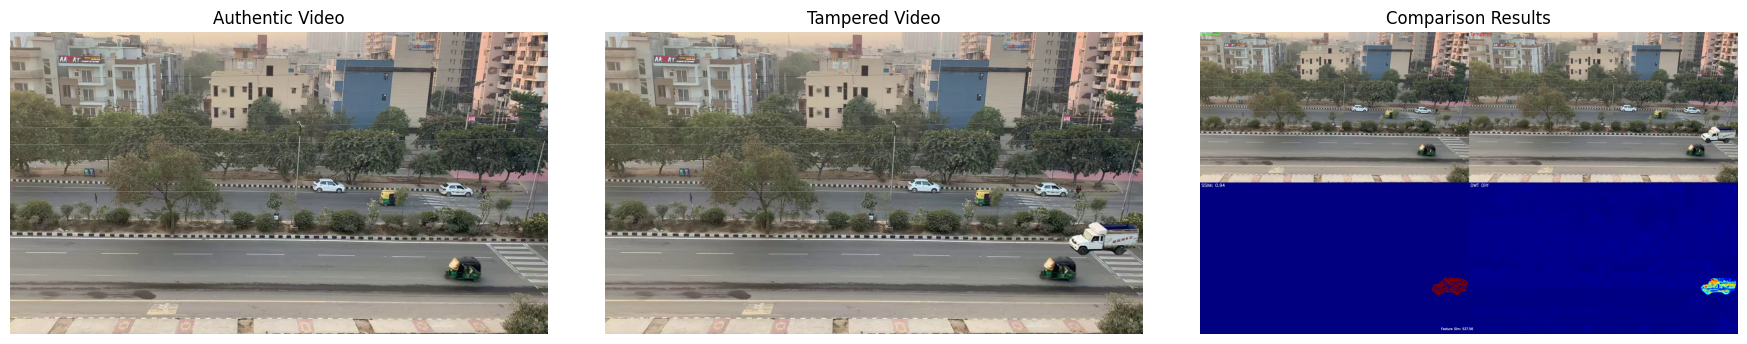

C:\Users\DEBASMITA\AppData\Local\Temp\ipykernel_13944\147169212.py:232: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  if plt.waitforbuttonpress(0.01):


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Reached end of video or processing error
Processing complete


In [ ]:
import cv2
import numpy as np
import pywt
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
import os

class VideoTamperingDetector:
    def __init__(self):
        # Force CPU usage
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
        
        # Initialize matplotlib
        plt.ion()
        self.fig, (self.ax1, self.ax2, self.ax3) = plt.subplots(1, 3, figsize=(18, 6))
        plt.tight_layout()
        
        # Load pre-trained CNN model (CPU-compatible)
        base_model = VGG16(weights='imagenet', include_top=False)
        self.feature_model = Model(inputs=base_model.input, 
                                 outputs=base_model.get_layer('block5_conv3').output)
        
        # Video capture objects
        self.au_cap = None
        self.tp_cap = None
        
        # Frame storage
        self.au_frame = None
        self.tp_frame = None
        self.result_frame = None
    
    def start_streams(self, au_video_path, tp_video_path):
        # Verify paths exist
        if not os.path.exists(au_video_path):
            print(f"Error: Authentic video not found at {au_video_path}")
            return False
        if not os.path.exists(tp_video_path):
            print(f"Error: Tampered video not found at {tp_video_path}")
            return False
        
        try:
            self.au_cap = cv2.VideoCapture(au_video_path)
            self.tp_cap = cv2.VideoCapture(tp_video_path)
            
            if not self.au_cap.isOpened():
                print(f"Couldn't open authentic video: {au_video_path}")
                return False
            if not self.tp_cap.isOpened():
                print(f"Couldn't open tampered video: {tp_video_path}")
                return False
            
            # Get video properties
            self.width = int(self.au_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            self.height = int(self.au_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            self.fps = self.au_cap.get(cv2.CAP_PROP_FPS)
            
            print(f"Video streams opened successfully")
            print(f"Resolution: {self.width}x{self.height}, FPS: {self.fps}")
            
            return True
            
        except Exception as e:
            print(f"Error opening video streams: {str(e)}")
            return False
    
    def process_frames(self):
        """Process one frame from each stream"""
        try:
            # Read frames
            au_ret, self.au_frame = self.au_cap.read()
            tp_ret, self.tp_frame = self.tp_cap.read()
            
            if not au_ret or not tp_ret:
                return False
            
            # Convert to RGB for processing
            au_rgb = cv2.cvtColor(self.au_frame, cv2.COLOR_BGR2RGB)
            tp_rgb = cv2.cvtColor(self.tp_frame, cv2.COLOR_BGR2RGB)
            
            # 1. Feature Extraction
            au_features = self._extract_features(au_rgb)
            tp_features = self._extract_features(tp_rgb)
            
            # 2. Feature Similarity
            feature_sim = self._feature_similarity(au_features, tp_features)
            
            # 3. SSIM Analysis
            ssim_map, ssim_score = self._ssim_analysis(au_rgb, tp_rgb)
            
            # 4. DWT Analysis
            dwt_diff = self._dwt_analysis(au_rgb, tp_rgb)
            
            # Create comparison visualization
            self.result_frame = self._create_comparison(
                au_rgb, tp_rgb, 
                feature_sim, ssim_map, ssim_score, dwt_diff
            )
            
            return True
            
        except Exception as e:
            print(f"Error processing frames: {str(e)}")
            return False
    
    def _extract_features(self, frame):
        """Extract CNN features from a frame (CPU-compatible)"""
        resized = cv2.resize(frame, (224, 224))
        img_array = np.expand_dims(resized, axis=0)
        img_array = preprocess_input(img_array.astype('float32'))
        features = self.feature_model.predict(img_array, verbose=0)
        return features
    
    def _feature_similarity(self, feat1, feat2):
        """Compute similarity between feature maps"""
        return np.linalg.norm(feat1 - feat2)
    
    def _ssim_analysis(self, frame1, frame2):
        """Perform SSIM analysis between frames"""
        gray1 = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
        gray2 = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)
        score, diff = ssim(gray1, gray2, full=True)
        diff = (diff * 255).astype("uint8")
        _, thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
        return thresh, score
    
    def _dwt_analysis(self, frame1, frame2):
        """Perform DWT-based difference analysis"""
        gray1 = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
        gray2 = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)
        coeffs1 = pywt.dwt2(gray1, 'haar')
        coeffs2 = pywt.dwt2(gray2, 'haar')
        cA1, _ = coeffs1
        cA2, _ = coeffs2
        diff = np.abs(cA1 - cA2)
        diff = cv2.resize(diff, (gray1.shape[1], gray1.shape[0]))
        diff_norm = cv2.normalize(diff, None, 0, 255, cv2.NORM_MINMAX)
        return diff_norm.astype('uint8')
    
    def _create_comparison(self, au_frame, tp_frame, feature_sim, ssim_map, ssim_score, dwt_diff):
        """Create comparison visualization"""
        au_bgr = cv2.cvtColor(au_frame, cv2.COLOR_RGB2BGR)
        tp_bgr = cv2.cvtColor(tp_frame, cv2.COLOR_RGB2BGR)
        
        # Resize analysis maps
        ssim_map_resized = cv2.resize(ssim_map, (self.width, self.height))
        dwt_diff_resized = cv2.resize(dwt_diff, (self.width, self.height))
        
        # Create heatmaps
        ssim_heat = cv2.applyColorMap(ssim_map_resized, cv2.COLORMAP_JET)
        dwt_heat = cv2.applyColorMap(dwt_diff_resized, cv2.COLORMAP_JET)
        
        # Create comparison image
        top_row = np.hstack((au_bgr, tp_bgr))
        bottom_row = np.hstack((ssim_heat, dwt_heat))
        comparison = np.vstack((top_row, bottom_row))
        
        # Add text annotations
        cv2.putText(comparison, "Authentic", (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(comparison, "Tampered", (self.width + 10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.putText(comparison, f"SSIM: {ssim_score:.2f}", (10, self.height + 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(comparison, "DWT Diff", (self.width + 10, self.height + 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(comparison, f"Feature Sim: {feature_sim:.2f}", 
                   (self.width - 200, self.height * 2 - 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        return comparison
    
    def display_frames(self):
        """Display frames using matplotlib"""
        self.ax1.clear()
        self.ax2.clear()
        self.ax3.clear()
        
        self.ax1.imshow(cv2.cvtColor(self.au_frame, cv2.COLOR_BGR2RGB))
        self.ax1.set_title("Authentic Video")
        self.ax1.axis('off')
        
        self.ax2.imshow(cv2.cvtColor(self.tp_frame, cv2.COLOR_BGR2RGB))
        self.ax2.set_title("Tampered Video")
        self.ax2.axis('off')
        
        self.ax3.imshow(cv2.cvtColor(self.result_frame, cv2.COLOR_BGR2RGB))
        self.ax3.set_title("Comparison Results")
        self.ax3.axis('off')
        
        plt.pause(0.01)
    
    def release(self):
        """Release resources"""
        if self.au_cap is not None:
            self.au_cap.release()
        if self.tp_cap is not None:
            self.tp_cap.release()
        plt.ioff()
        plt.close()

def main():
    au_video_path = r"video\real\Clone_Auth1.mp4"  
    tp_video_path = r"video\fake\clone1.mp4"      
    
    # Initialize detector
    detector = VideoTamperingDetector()
    
    # Start video streams
    if not detector.start_streams(au_video_path, tp_video_path):
        print("Failed to start video streams. Please check:")
        print(f"1. File paths are correct (current paths: {au_video_path}, {tp_video_path})")
        print("2. Video files exist and are valid")
        print("3. You have read permissions for the files")
        return
    
    # Main processing loop
    try:
        while True:
            if not detector.process_frames():
                print("Reached end of video or processing error")
                break
            
            detector.display_frames()
            
            # Check for quit command
            if plt.waitforbuttonpress(0.01):
                break
                
    except KeyboardInterrupt:
        print("Processing interrupted")
    finally:
        detector.release()
        print("Processing complete")

if __name__ == "__main__":
    main()

<h1> TAMPER RECOVERY USING RESNET50</h1>

In [ ]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    """Load and preprocess image for CNN feature extraction"""
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found at path: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img, img_array

def extract_cnn_features(model, img_array):
    """Extract features using pre-trained CNN"""
    return model.predict(img_array)

def compute_feature_similarity(feat1, feat2):
    """Compute similarity between CNN features"""
    return np.linalg.norm(feat1 - feat2)

def detect_tampered_regions(authentic_img, tampered_img, window_size=7):
    """Detect tampered regions using SSIM"""
    authentic_gray = cv2.cvtColor(authentic_img, cv2.COLOR_RGB2GRAY)
    tampered_gray = cv2.cvtColor(tampered_img, cv2.COLOR_RGB2GRAY)
    
    score, diff = ssim(authentic_gray, tampered_gray, full=True, win_size=window_size)
    
    diff = (diff * 255).astype("uint8")
    _, threshold_map = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    
    return threshold_map, score

def recover_tampered_image(authentic_img, tampered_img, threshold_map):
    """Recover tampered image using DWT"""
    authentic_gray = cv2.cvtColor(authentic_img, cv2.COLOR_RGB2GRAY)
    tampered_gray = cv2.cvtColor(tampered_img, cv2.COLOR_RGB2GRAY)
    
    authentic_coeffs = pywt.dwt2(authentic_gray, 'haar')
    tampered_coeffs = pywt.dwt2(tampered_gray, 'haar')
    
    authentic_cA, (authentic_cH, authentic_cV, authentic_cD) = authentic_coeffs
    tampered_cA, (tampered_cH, tampered_cV, tampered_cD) = tampered_coeffs
    
    threshold_map_resized = cv2.resize(threshold_map, 
                                       (authentic_cA.shape[1], authentic_cA.shape[0]), 
                                       interpolation=cv2.INTER_NEAREST)
    
    recovered_cA = np.where(threshold_map_resized > 0, authentic_cA, tampered_cA)
    
    recovered_image = pywt.idwt2((recovered_cA, (tampered_cH, tampered_cV, tampered_cD)), 'haar')
    recovered_image = np.clip(recovered_image, 0, 255).astype(np.uint8)
    
    return recovered_image

def combined_tampering_detection(authentic_path, tampered_path):
    # Load and preprocess images
    authentic_img, authentic_array = load_and_preprocess_image(authentic_path)
    tampered_img, tampered_array = load_and_preprocess_image(tampered_path)
    
    # Load ResNet50 model without top layers
    base_model = ResNet50(weights='imagenet', include_top=False)
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('conv5_block3_out').output)
    
    # Extract features
    authentic_features = extract_cnn_features(model, authentic_array)
    tampered_features = extract_cnn_features(model, tampered_array)
    
    # Compute feature similarity
    feature_similarity = compute_feature_similarity(authentic_features, tampered_features)
    print(f"Feature similarity score: {feature_similarity}")
    
    # Detect tampered regions
    threshold_map, ssim_score = detect_tampered_regions(authentic_img, tampered_img)
    print(f"SSIM score: {ssim_score}")
    
    # Recover tampered image
    recovered_image = recover_tampered_image(authentic_img, tampered_img, threshold_map)
    
    # Display results
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.title("Authentic Image")
    plt.imshow(authentic_img)
    plt.axis("off")
    
    plt.subplot(2, 3, 2)
    plt.title("Tampered Image")
    plt.imshow(tampered_img)
    plt.axis("off")
    
    plt.subplot(2, 3, 3)
    plt.title("Feature Similarity Heatmap")
    feat_diff = np.mean(np.abs(authentic_features - tampered_features), axis=-1).squeeze()
    plt.imshow(feat_diff, cmap='hot')
    plt.colorbar()
    plt.axis("off")
    
    plt.subplot(2, 3, 4)
    plt.title("SSIM Difference Map")
    plt.imshow(threshold_map, cmap='gray')
    plt.axis("off")
    
    plt.subplot(2, 3, 5)
    plt.title("Recovered Image (DWT)")
    plt.imshow(recovered_image, cmap='gray')
    plt.axis("off")
    
    plt.subplot(2, 3, 6)
    plt.title("Recovered Regions")
    recovered_mask = cv2.resize(threshold_map, (recovered_image.shape[1], recovered_image.shape[0]))
    highlighted = cv2.merge([recovered_image, recovered_image, recovered_image])
    highlighted[:, :, 0] = np.where(recovered_mask > 0, 255, highlighted[:, :, 0]) 
    plt.imshow(highlighted)
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Feature similarity score: 276.7236022949219
SSIM score: 0.9060660888868365


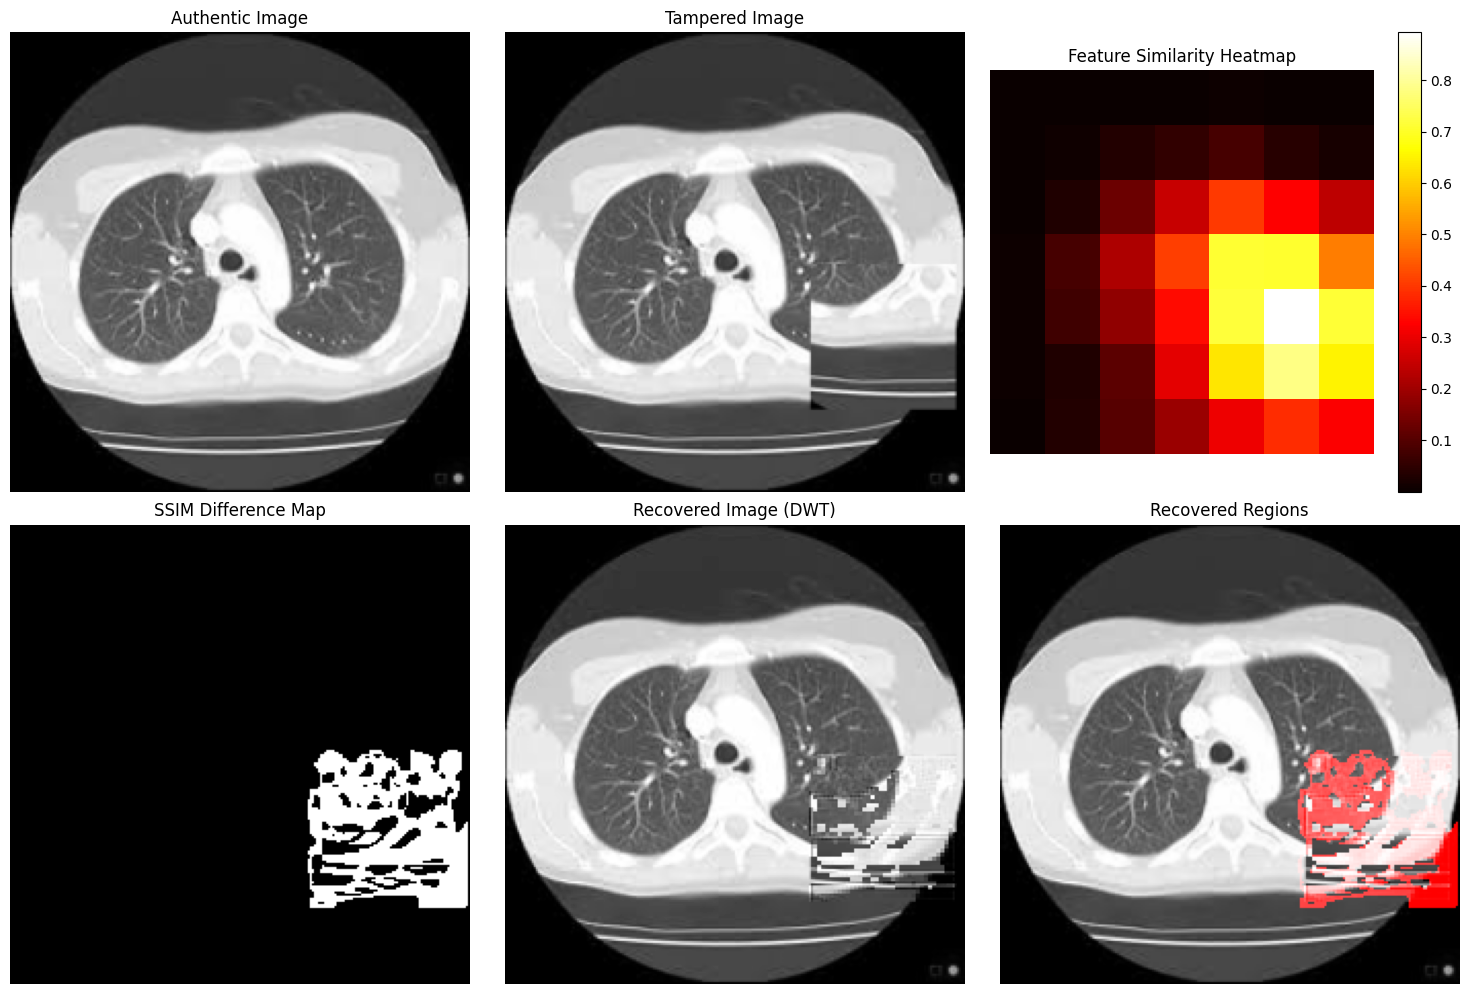

In [3]:
# Example usage
authentic_path = r"Medical_dataset\Real\original\original (1).png"
tampered_path = r"Medical_dataset\Fake\copy_move\copy_move\copy_move (1).png"
combined_tampering_detection(authentic_path, tampered_path)

In [ ]:
import cv2
import numpy as np
import pywt
import os
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from transformers import ViTFeatureExtractor, ViTModel
import torch
import matplotlib.pyplot as plt

# Initialize ViT and ResNet
resnet_base = ResNet50(weights='imagenet', include_top=False)
resnet_model = Model(inputs=resnet_base.input, outputs=resnet_base.get_layer('conv5_block3_out').output)
vit_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)

def preprocess_frame_resnet(frame):
    img = cv2.resize(frame, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

def extract_vit_features(frame):
    img = cv2.resize(frame, (224, 224))
    inputs = vit_extractor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = vit_model(**inputs)
    return outputs.last_hidden_state.cpu().numpy()

def compute_similarity(f1, f2):
    return np.linalg.norm(f1 - f2)

def detect_tampered_regions(auth_frame, tamp_frame):
    gray1 = cv2.cvtColor(auth_frame, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(tamp_frame, cv2.COLOR_BGR2GRAY)
    score, diff = ssim(gray1, gray2, full=True)
    diff = (diff * 255).astype("uint8")
    _, thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    return thresh, score

def recover_frame(auth_frame, tamp_frame, mask):
    gray_auth = cv2.cvtColor(auth_frame, cv2.COLOR_BGR2GRAY)
    gray_tamp = cv2.cvtColor(tamp_frame, cv2.COLOR_BGR2GRAY)
    auth_coeffs = pywt.dwt2(gray_auth, 'haar')
    tamp_coeffs = pywt.dwt2(gray_tamp, 'haar')
    auth_cA, (auth_cH, auth_cV, auth_cD) = auth_coeffs
    tamp_cA, (tamp_cH, tamp_cV, tamp_cD) = tamp_coeffs
    mask_resized = cv2.resize(mask, (auth_cA.shape[1], auth_cA.shape[0]), interpolation=cv2.INTER_NEAREST)
    recovered_cA = np.where(mask_resized > 0, auth_cA, tamp_cA)
    recovered = pywt.idwt2((recovered_cA, (tamp_cH, tamp_cV, tamp_cD)), 'haar')
    return np.clip(recovered, 0, 255).astype(np.uint8)

def process_video(auth_path, tamp_path, output_path="recovered_video.avi", max_frames=300):
    cap1 = cv2.VideoCapture(auth_path)
    cap2 = cv2.VideoCapture(tamp_path)
    
    width = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap1.get(cv2.CAP_PROP_FPS)
    
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (width, height), isColor=False)
    
    frame_count = 0
    while True:
        ret1, frame1 = cap1.read()
        ret2, frame2 = cap2.read()
        if not ret1 or not ret2 or frame_count >= max_frames:
            break
        
        # ResNet + ViT features
        res_feat1 = resnet_model.predict(preprocess_frame_resnet(frame1))
        res_feat2 = resnet_model.predict(preprocess_frame_resnet(frame2))
        res_sim = compute_similarity(res_feat1, res_feat2)
        
        vit_feat1 = extract_vit_features(frame1)
        vit_feat2 = extract_vit_features(frame2)
        vit_sim = compute_similarity(vit_feat1, vit_feat2)
        
        print(f"[Frame {frame_count}] ResNet sim: {res_sim:.2f}, ViT sim: {vit_sim:.2f}")
        
        # Tampering detection
        mask, ssim_score = detect_tampered_regions(frame1, frame2)
        print(f"[Frame {frame_count}] SSIM: {ssim_score:.3f}")
        
        # Recovery
        recovered = recover_frame(frame1, frame2, mask)
        out.write(recovered)
        frame_count += 1
    
    cap1.release()
    cap2.release()
    out.release()
    print("Recovery video saved.")

process_video(r"video\real\Clone_Auth2.mp4", r"video\fake\clone2.mp4")


d:\local_drive\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\local_drive\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
[Frame 0] ResNet sim: 290.70, ViT sim: 37.73
[Frame 0] SSIM: 0.763
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
[Frame 1] ResNet sim: 317.63, ViT sim: 36.84
[Frame 1] SSIM: 0.765
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
[Frame 2] ResNet sim: 312.20, ViT sim: 39.02
[Frame 2] SSIM: 0.765
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
[Frame 3] ResNet sim: 309.54, ViT sim: 37.55
[Frame 3] SSIM: 0.765
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
[Frame 4] ResNet sim: 292.70, ViT sim: 40.24
[Frame 4] SSIM: 0.764
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
[Frame 5] ResNet sim: 308.07, ViT sim: 36.12
[Frame 5] SSIM: 0.766
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
[Frame 6] ResNet sim: 326.62, ViT sim: 36.14
[Frame 6] 